# Final Project: astropy.io
Author: Oguz Tanatar

Date: 05/15/2025

Let's first import the astropy.io package, and some other dependencies. 

In [1]:
from astropy.io import fits 
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS #we will use this later on to convert pixels to physical quantities

### Opening Fits

First import data from the given FITS Cubes:

In [2]:
hdul = fits.open('PHYS265-data/data/ngc6503.fits') #hdul = HDU List
print(hdul.info(), '\nLength of the HDU List', len(hdul)) 


Filename: PHYS265-data/data/ngc6503.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     429   (256, 256, 31, 1)   float32   
None 
Length of the HDU List 1


The general layout of an HDU (header data unit) List has two big parts. The header, describing what the data is, and the data (which is self-expalanatory). We extract them as follows.

In [3]:
hdu = hdul[0]
hdr = hdu.header
data = hdu.data
print(hdr)


SIMPLE  =                    T /                                                BITPIX  =                  -32 /                                                NAXIS   =                    4 /                                                NAXIS1  =                  256 /                                                NAXIS2  =                  256 /                                                NAXIS3  =                   31 /                                                NAXIS4  =                    1 /                                                EXTEND  =                    T /Tables following main image                     BLOCKED =                    T /Tape may be blocked                             OBJECT  = 'NGC6503 '                                                            TELESCOP= '        '                                                            INSTRUME= '        '                                                            OBSERVER= 'WELL    '                    

Obviously, this is quite difficult to read. Instead, we can utilize the keys attribute of the header unit to enumerate the values in the header. This will allow us to more easily read what the individual quantities in the header mean. There is another attribute corresponding to keys, called values, which contains each value corresponding to each key. These can be read as follows:

In [4]:
for key, value in hdr.items():
    print(f"{key}: {value}")

SIMPLE: True
BITPIX: -32
NAXIS: 4
NAXIS1: 256
NAXIS2: 256
NAXIS3: 31
NAXIS4: 1
EXTEND: True
BLOCKED: True
OBJECT: NGC6503
TELESCOP: 
INSTRUME: 
OBSERVER: WELL
DATE-OBS: 12/04/83
DATE-MAP: 20/09/84
BSCALE: 1.0
BZERO: 0.0
BUNIT: JY/BEAM
EPOCH: 1950.0
VELREF: 2706
ALTRVAL: 1420274882.0
ALTRPIX: 1.0
RESTFREQ: 1420405751.0
DATAMAX: 0.0295377057
DATAMIN: -0.01367387734
CTYPE1: RA---SIN
CRVAL1: 267.490455508
CDELT1: -0.001666666707
CRPIX1: 128.0
CROTA1: 0.0
CTYPE2: DEC--SIN
CRVAL2: 70.1571384072
CDELT2: 0.001666666707
CRPIX2: 129.0
CROTA2: 0.0
CTYPE3: FELO-HEL
CRVAL3: 26000.0
CDELT3: -10307.61914
CRPIX3: 16.0
CROTA3: 0.0
CTYPE4: STOKES
CRVAL4: 1.0
CDELT4: 1.0
CRPIX4: 1.0
CROTA4: 0.0
HISTORY: --------------------------------------------------------------------
HISTORY: /Begin "HISTORY" information found in fits tape header by IMLOD
HISTORY: BLOCKED =                    T /Tape may be blocked
HISTORY: --------------------------------------------------------------------
HISTORY: /Begin "HISTORY"

#### Explaining the Header
We now have a readable, although intimidating, list of values in the headers. Here is a quick glossary of what some individual, commonly used, keys mean: 

SIMPLE: Whether the file conforms to FITS standards

BITPIX: The number of bits per data pixel

NAXIS: The number of axes in the data

NAXIS[n]: The number of pixels in the nth axis

HISTORY: Adding extra information to the file's documentation


### Visualizing Data (10/11/12)
We will specifically focusing on the spectral lines at the middle of the fits cube, at the pixels x = 128, y = 128.  


DEC--SIN
(1, 31, 256, 256)
20
closest_idx = 20 type: <class 'numpy.int64'>
(256, 256)


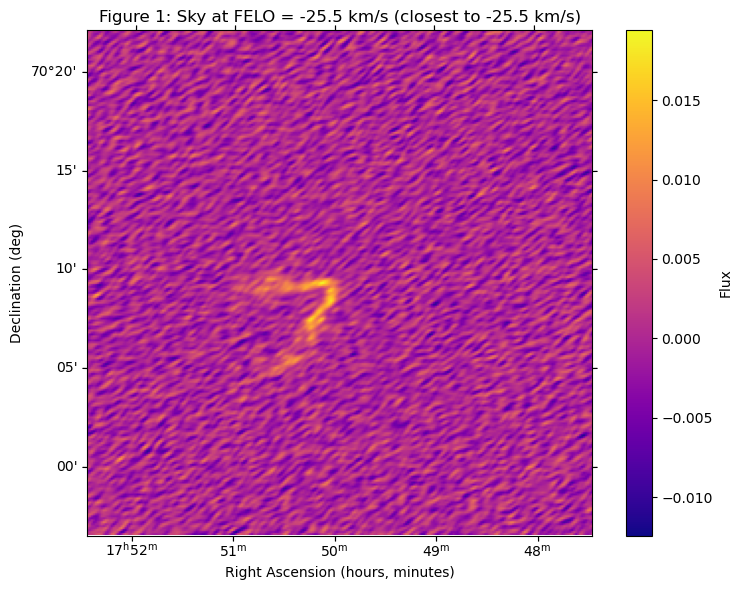

In [5]:
print(hdr['CTYPE2'])
print(data.shape) #from this, we find our cube is 4-dimensional. The axes correspond to (polarization, spectral channels, DEC--SIN, RA---SIN)
data_squeeze = data[0]

for i in range(1, 5):
    if hdr.get(f'CTYPE{i}', '') == 'FELO-HEL': #displaying astropy.io's capability to change header key titles
        hdr[f'CTYPE{i}'] = 'VELO-LSR'

#Converting the invalid FELO-HEL parameter type to the more parameter type VELO-LSR. 
#We will eventually pick out a certain one of these values, so it should not affect the output at the end.
# We only really change what we call it to translate to astropy. The data remains unchanged.  
w = WCS(hdr, naxis=3)  # just using the 3 axes, so we say naxis = 3. 


velocity_pixel = np.arange(data_squeeze.shape[0])
velocity_coords = w.pixel_to_world_values(
    np.zeros_like(velocity_pixel),  # RA pixel
    np.zeros_like(velocity_pixel),  # Dec pixel
    velocity_pixel                  # Spec pixel
)
velocities = velocity_coords[2]  # velocities in m/s


felo = -25458 #use this line to declare a felo value you want to use. 
closest_index = np.argmin(np.abs(velocities - felo))
print(closest_index)
acc_velocity = velocities[closest_index]
sky_slice = data_squeeze[closest_index, :, :]
#Slicing the cube
      # 2D image at that velocity
# We cut our data unit down from 3 dimensions to 2, so we shoul slice the WSC accordingly. 
w2d = w.slice([closest_index]) 
print("closest_idx =", closest_index, "type:", type(closest_index))
print(sky_slice.shape)

#Plotting

plt.figure(figsize=(8, 6))
ax = plt.subplot(projection=w2d)
im = ax.imshow(sky_slice, origin='lower', cmap='plasma')
ax.set_title(f"Figure 1: Sky at FELO = {acc_velocity/1e3:.1f} km/s (closest to {felo/1e3:.1f} km/s)")
ax.set_xlabel("Right Ascension (hours, minutes)")
ax.set_ylabel("Declination (deg)")
plt.colorbar(im, ax=ax, label="Flux")
plt.tight_layout()
plt.show()



